# 1. Custom training loop

In [1]:
import tensorflow as tf
import tensorflow.keras as kr
import tensorflow.keras.layers as layers
import numpy as np

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split 

random_seed=42
tf.random.set_seed(random_seed)


2025-02-25 23:16:35.142998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


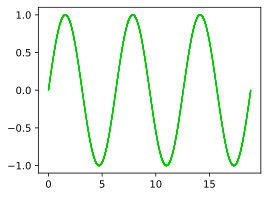

In [2]:
# Creating a simple dataset
X=np.linspace(0,6*np.pi,10000,dtype=np.float32)
y=np.sin(X)

plt.figure(figsize=(4,3))
plt.scatter(X,y,s=0.1,color=(0,0.8,0,1))
plt.show()

# train-test-split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=random_seed)

# convert into tensors, and reshape correctly
X_train,X_test=tf.expand_dims(tf.constant(X_train,dtype=tf.float32),-1),tf.expand_dims(tf.constant(X_test,dtype=tf.float32),-1)

# creating training and testing datasets
train_dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_dataset=tf.data.Dataset.from_tensor_slices((X_test,y_test))

# creating train and test loader
batch_size=16
# train_loader=train_dataset.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)
# test_loader=test_dataset.shuffle(len(test_dataset)).prefetch(tf.data.AUTOTUNE)

### without shuffling
train_loader=train_dataset.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)
test_loader=test_dataset.prefetch(tf.data.AUTOTUNE)

In [3]:
# accessing first 5 samples
for X,y in train_dataset.take(5):
    print(X,y)

tf.Tensor([17.445124], shape=(1,), dtype=float32) tf.Tensor(-0.98619336, shape=(), dtype=float32)
tf.Tensor([2.94271], shape=(1,), dtype=float32) tf.Tensor(0.19757421, shape=(), dtype=float32)
tf.Tensor([3.1481907], shape=(1,), dtype=float32) tf.Tensor(-0.0065980353, shape=(), dtype=float32)
tf.Tensor([11.474873], shape=(1,), dtype=float32) tf.Tensor(-0.88731873, shape=(), dtype=float32)
tf.Tensor([12.572026], shape=(1,), dtype=float32) tf.Tensor(0.005655608, shape=(), dtype=float32)


2025-02-25 23:16:37.872869: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
X,y=next(iter(test_loader))

X,y

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([11.785921], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.7035989165306091>)

In [18]:
class Model(tf.keras.Sequential):
    def __init__(self,lr=0.01,metrics=['mae']):
        # calling constructor of Sequential class with model name
        super().__init__(name='model1')

        # Adding layers:
        
        ### hidden layers
        self.add(layers.Dense(10,input_shape=[1],name='hl1',activation='tanh'))
        self.add(layers.Dense(10,name='hl2',activation='tanh'))

        ### output layers
        self.add(layers.Dense(1,name='output_layer'))

        # defining other hyperparameters
        self.loss_function=tf.keras.losses.mse
        self.optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
        self.eval_metrics=metrics

model=Model()
model.summary()

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hl1 (Dense)                     │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hl2 (Dense)                     │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def train_model(model,train_loader,epochs,validation_loader=None,verbose=True):
    # initialize losses
    losses=np.zeros(epochs)
    val_loss=np.zeros(epochs)

    for epochi in range(epochs):
        #  -- training --
        batch_loss=[] # to store batch loss
        for (X_batch,y_batch) in train_loader:
            with tf.GradientTape() as tape:
                y_pred=model(X_batch,training=True) # forward propogation
                loss=model.loss_function(y_pred,y_batch)
            
            batch_loss.append(loss)
            
            # back propogation
            gradients=tape.gradient(loss,model.trainable_weights)
            model.optimizer.apply_gradients(zip(gradients,model.trainable_weights))

            # updating metrics
            model.compiled_metrics.update(y,y_pred)


        losses[epochi]=tf.reduce_mean(batch_loss)

        if validation_loader is not None:
            X,y=next(iter(validation_loader))
            y_pred=model(X,training=False)
            val_loss[epochi]=model.loss_function(y_pred,y)

        # displaying status
        if validation_loader is not None:
            print(f'{epochi+1}/{epochs} complete. Training loss: {losses[epochi]}, Validation loss: {val_loss[epochi]}')
        else:
            print(f'{epochi+1}/{epochs} complete. Training loss: {losses[epochi]}')
            

    return tf.constant(losses),tf.constant(val_loss),model

In [7]:
# training model (fitting)
losses,val_loss,model=train_model(model=model,
                                  train_loader=train_loader,epochs=5,validation_loader=test_loader)

2025-02-25 23:16:47.200291: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/5 complete. Training loss: 0.40368127822875977, Validation loss: 0.5431358814239502
2/5 complete. Training loss: 0.32428544759750366, Validation loss: 0.5961754322052002


2025-02-25 23:17:05.202071: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3/5 complete. Training loss: 0.29794183373451233, Validation loss: 0.4263264834880829
4/5 complete. Training loss: 0.25655966997146606, Validation loss: 0.3296768069267273
5/5 complete. Training loss: 0.222303569316864, Validation loss: 0.12955570220947266


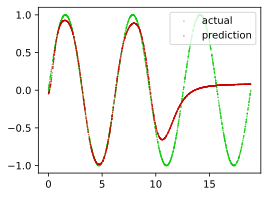

In [8]:
y_pred=model(X_test,training=False)
plt.figure(figsize=(4,3))
plt.scatter(X_test,y_test,s=0.1,color=(0,0.8,0,1),label='actual')
plt.scatter(X_test,y_pred,s=0.1,color=(0.8,0,0,1),label='prediction')
plt.legend()
plt.show()

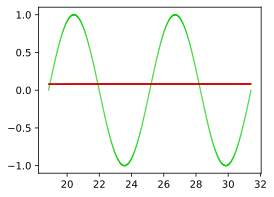

In [9]:
X_1=tf.constant(np.linspace(6*np.pi,10*np.pi,1000),dtype=tf.float32)
y_1=np.sin(X_1)
y_pred=model(X_1,training=False)
plt.figure(figsize=(4,3))
plt.scatter(X_1,y_1,s=0.1,color=(0,0.8,0,1))
plt.scatter(X_1,y_pred,s=0.1,color=(0.8,0,0,1))
plt.show()

**Model 2**
* training with batch size=1

In [10]:
X_train.shape

TensorShape([8000, 1])

In [11]:
model_2 = Model()
model_2.compile(loss=model_2.loss_function,optimizer=model_2.optimizer,metrics=model_2.eval_metrics)

In [12]:
model_2.fit(x=X_train,y=y_train,batch_size=1,epochs=20)

Epoch 1/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.4217 - mae: 0.5347
Epoch 2/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2752 - mae: 0.3860
Epoch 3/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.2662 - mae: 0.3728
Epoch 4/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.2641 - mae: 0.3689
Epoch 5/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.2634 - mae: 0.3691
Epoch 6/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2674 - mae: 0.3722
Epoch 7/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2628 - mae: 0.3670
Epoch 8/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2628 - mae: 0.3688
Epoch 9/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2650 - mae: 0.3712
Epoch 10/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2624 - mae: 0.3652
Epoch 11/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.2664 - mae: 0.3695
Epoch 12/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.2660 - mae: 0.

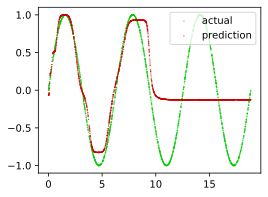

In [13]:
y_pred=model_2(X_test,training=False)
plt.figure(figsize=(4,3))
plt.scatter(X_test,y_test,s=0.1,color=(0,0.8,0,1),label='actual')
plt.scatter(X_test,y_pred,s=0.1,color=(0.8,0,0,1),label='prediction')
plt.legend()
plt.show()

**Model 3**

In [19]:
model_3 = Model()
model_3.compile(loss=model_3.loss_function,optimizer=model_3.optimizer,metrics=model_3.eval_metrics)

In [20]:
model_3.fit(train_loader,epochs=5)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4587 - mae: 0.5722
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3423 - mae: 0.4592
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2936 - mae: 0.4085
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2571 - mae: 0.3649
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2360 - mae: 0.3311


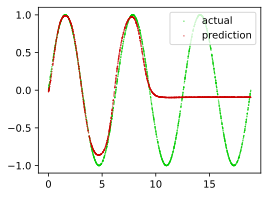

In [21]:
y_pred=model_3(X_test,training=False)
plt.figure(figsize=(4,3))
plt.scatter(X_test,y_test,s=0.1,color=(0,0.8,0,1),label='actual')
plt.scatter(X_test,y_pred,s=0.1,color=(0.8,0,0,1),label='prediction')
plt.legend()
plt.show()

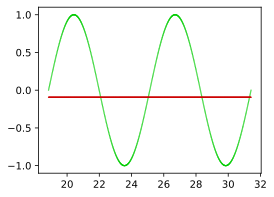

In [22]:
X_1=tf.constant(np.linspace(6*np.pi,10*np.pi,1000),dtype=tf.float32)
y_1=np.sin(X_1)
y_pred=model_3(X_1,training=False)
plt.figure(figsize=(4,3))
plt.scatter(X_1,y_1,s=0.1,color=(0,0.8,0,1))
plt.scatter(X_1,y_pred,s=0.1,color=(0.8,0,0,1))
plt.show()